[*********************100%***********************]  1 of 1 completed
11/11 [==============================] - 0s 2ms/step
RMSE: 5.304749834624338
MAE: 4.503543911037502
R2: 0.8912765069165932
MAPE: 0.03%
Theil U statistic (LSTM): 0.03
Profit/Loss after 332 time steps: $78.01


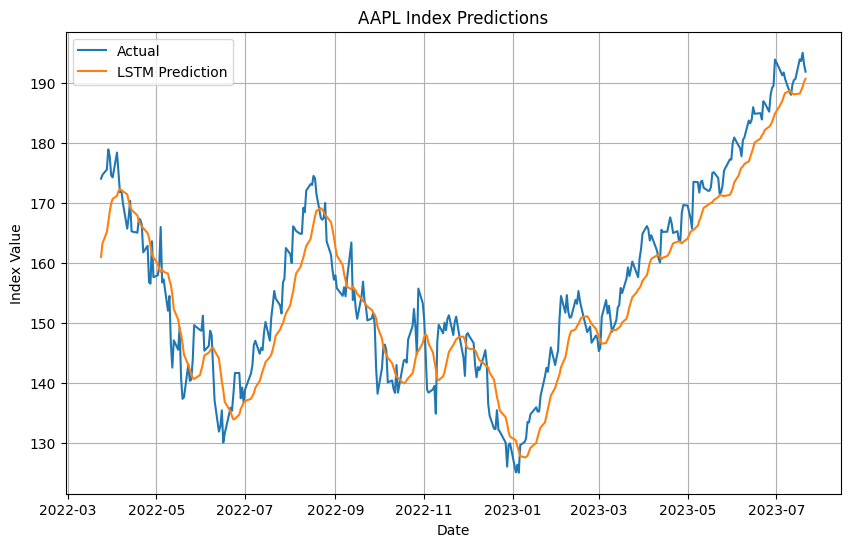

In [3]:
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import yfinance as yf
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter("ignore")

tf.random.set_seed(455)
np.random.seed(455)

ticker = "AAPL"
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download(ticker, start, end)
dataset

# Preprocess the data
data = dataset['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


# Function to create sequences for LSTM models
def create_dataset(dataset, time_steps=1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        data_X.append(a)
        data_Y.append(dataset[i + time_steps, 0])
    return np.array(data_X), np.array(data_Y)


# Define sequence length
sequence_length = 20

# Create sequences for LSTM models
X_train, y_train = create_dataset(train_data, sequence_length)
X_test, y_test = create_dataset(test_data, sequence_length)

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

# Generate predictions for the LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)


# Function to calculate Theil U statistic
def theil_u_statistic(actual, predicted, naive):
    mse_actual = mean_squared_error(actual, naive)
    mse_predicted = mean_squared_error(actual, predicted)
    theil_u = np.sqrt(mse_predicted / mse_actual)
    return theil_u


# Generate naive predictions (using the last value in the training set)
naive_predictions = np.full_like(y_test, y_train[-1])

# Calculate indexes
lstm_rmse = np.sqrt(mean_squared_error(data[train_size + sequence_length:], lstm_predictions))
lstm_mae = mean_absolute_error(data[train_size + sequence_length:], lstm_predictions)
lstm_r2 = r2_score(data[train_size + sequence_length:], lstm_predictions)
lstm_mape = mean_absolute_percentage_error(data[train_size + sequence_length:], lstm_predictions)
lstm_theil_u = theil_u_statistic(data[train_size + sequence_length:], lstm_predictions, naive_predictions)

print(f"RMSE: {lstm_rmse}")
print(f"MAE: {lstm_mae}")
print(f"R2: {lstm_r2}")
print(f"MAPE: {lstm_mape:.2f}%")
print(f"Theil U statistic (LSTM): {lstm_theil_u:.2f}")


# Decide whether to buy or sell the stock based on predicted price movements
def decide_action(predictions):
    actions = []
    for i in range(len(predictions) - 1):
        if predictions[i + 1] > predictions[i]:
            actions.append('buy')
        else:
            actions.append('sell')
    return actions


lstm_predictions_list = lstm_predictions.flatten().tolist()
actions = decide_action(lstm_predictions_list)


# Function to calculate profit or loss
def calculate_profit_loss(actions, test_data, data, sequence_length):
    capital = 10000  # Starting capital
    stock_units = 0
    stock_price = 0
    for i in range(len(actions)):
        if actions[i] == 'buy':
            stock_units = capital // data[train_size + sequence_length + i]
            stock_price = data[train_size + sequence_length + i]
            capital -= stock_units * stock_price
        elif actions[i] == 'sell':
            if stock_units > 0:
                capital += stock_units * data[train_size + sequence_length + i]
                stock_units = 0
    if stock_units > 0:
        capital += stock_units * data[train_size + sequence_length - 1]  # Sell remaining stocks at the last price
    return capital


N_time_steps = len(actions)
profit_loss = calculate_profit_loss(actions, test_data, data, sequence_length)
profit_loss = float(profit_loss)
print(f"Profit/Loss after {N_time_steps} time steps: ${profit_loss:.2f}")

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size + sequence_length:], data[train_size + sequence_length:], label='Actual')
plt.plot(dataset.index[train_size + sequence_length:], lstm_predictions_list, label='LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()
